In [1]:
import warnings
import numpy as np
import xarray as xr
from numba import jit
import proplot as pplt
from matplotlib.lines import Line2D
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
MONTHPAIRS    = [(6,7),(7,8)]
SAMPLETHRESH  = 50
NITERATIONS   = 1000
YEARSINSAMPLE = 5

In [3]:
def load(filename,varlist,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds[varlist].load()

In [4]:
hiresimergds = load('ERA5_IMERG_pr_bl_terms.nc',varlist=['pr','bl'])
loresimergds = load('LOW_ERA5_IMERG_pr_bl_terms.nc',varlist=['pr','bl'])
loresgpcpds  = load('ERA5_GPCP_pr_bl_terms.nc',varlist=['pr','bl'])

## Fig. 4

 Use ```calc_actual_pr_diffs()``` to calculate the actual and predicted precipitation differences for each subregion.

Use bootstrapping to estimate the uncertainty around these actual differences. Bootstrapping involves: a. Repeatedly resampling your data with replacement b. Calculating the statistic of interest (in this case, precipitation differences) for each resampled dataset c. Using the distribution of these bootstrap statistics to estimate the uncertainty of your actual statistic

Calculate the 95% confidence interval from the bootstrap distribution. This gives you the "error bars" to apply to your actual precipitation differences.

In [5]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,months):
    if not isinstance(months,(list,tuple)):
        months = [months]
    monthmask = data.time.dt.month.isin(months)
    return data.sel(time=monthmask)

def get_bin_edges(key,binparams=BINPARAMS):
    varname  = binparams[key]
    binedges = np.arange(varname['min'],varname['max']+varname['width'],varname['width'])
    return binedges
    
@jit(nopython=True)
def fast_binned_stats(bl,pr,blbinmin,blbinwidth,nblbins):
    Q0 = np.zeros(nblbins)
    Q1 = np.zeros(nblbins)
    blidxs = ((bl-blbinmin)/blbinwidth+0.5).astype(np.int32)
    for i in range(bl.size):
        blidx = blidxs.flat[i]
        prval = pr.flat[i]
        if 0<=blidx<nblbins and np.isfinite(prval):
            Q0[blidx] += 1
            Q1[blidx] += prval
    return Q0,Q1

def calc_binned_stats(data,binparams=BINPARAMS):
    blbins  = get_bin_edges('bl',binparams)
    nblbins = blbins.size
    blbinmin   = binparams['bl']['min']
    blbinwidth = binparams['bl']['width']
    Q0,Q1 = fast_binned_stats(data.bl.values,data.pr.values,blbinmin,blbinwidth,nblbins)
    ds = xr.Dataset(data_vars={'Q0':(('bl'),Q0),'Q1':(('bl'),Q1)},coords={'bl':blbins})
    ds.Q0.attrs = dict(long_name='Count of points in each bin')
    ds.Q1.attrs = dict(long_name='Sum of precipitation in each bin',units='mm/day')
    ds.bl.attrs = dict(long_name='Average buoyancy in the lower troposphere', units='m/s²')
    return ds

def get_bootstrap_samples(data,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE):
    allyears = np.unique(data.time.dt.year.values)
    nyears   = len(allyears)
    yearidxs = np.random.choice(nyears,size=(niterations,yearsinsample),replace=True)
    samples = []
    for iterationidxs in yearidxs:
        selectedyears = allyears[iterationidxs]
        sample = data.sel(time=data.time.dt.year.isin(selectedyears))
        samples.append(sample)
    return samples

def calc_real_monthly_pr(monthdata):
    return monthdata.pr.mean(dim=['lat','lon','time']).values

def calc_predicted_monthly_pr(monthstats,regionstats,samplethresh=SAMPLETHRESH):
    blpdf     = (monthstats.Q0/np.nansum(monthstats.Q0)).where(monthstats.Q0>=samplethresh)
    binmeanpr = (regionstats.Q1/regionstats.Q0).where(regionstats.Q0>=samplethresh)
    return np.nansum(blpdf*binmeanpr)

def calc_pr_diffs_for_region(regiondata,monthpair,samplethresh=SAMPLETHRESH):
    realmonthprlist = []
    predmonthprlist = []
    regionstats = calc_binned_stats(regiondata)
    for month in monthpair:
        monthdata  = get_month(regiondata,month)
        monthstats = calc_binned_stats(monthdata)
        realmonthprlist.append(calc_real_monthly_pr(monthdata))
        predmonthprlist.append(calc_predicted_monthly_pr(monthstats,regionstats,samplethresh))
    realprdiff = realmonthprlist[1]-realmonthprlist[0]
    predprdiff = predmonthprlist[1]-predmonthprlist[0]
    return realprdiff,predprdiff

def calc_actual_pr_diffs(data,regions=REGIONS,samplethresh=SAMPLETHRESH):
    regionnames    = []
    realprdifflist = []
    predprdifflist = []
    for i,region in enumerate(regions):
        regionnames.append(region)
        monthpair  = MONTHPAIRS[0] if i<3 else MONTHPAIRS[1]
        regiondata = get_month(get_region(data,region),monthpair)
        realprdiff,predprdiff = calc_pr_diffs_for_region(regiondata,monthpair,samplethresh)
        realprdifflist.append(realprdiff)
        predprdifflist.append(predprdiff)
    return (xr.DataArray(realprdifflist,dims=['region'],coords={'region':regionnames}),
            xr.DataArray(predprdifflist,dims=['region'],coords={'region':regionnames}))

def calc_bootstrapped_pr_diffs(data,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE,regions=REGIONS,samplethresh=SAMPLETHRESH):
    regionnames         = []
    realprdiffensemble = []
    predprdiffensemble = []
    for i,region in enumerate(regions):
        regionnames.append(region)
        monthpair  = MONTHPAIRS[0] if i<3 else MONTHPAIRS[1]
        regiondata = get_month(get_region(data,region),monthpair)
        samples    = get_bootstrap_samples(regiondata,niterations,yearsinsample)
        realprdiffsamples = []
        predprdiffsamples = []
        for sample in samples:
            realprdiff,predprdiff = calc_pr_diffs_for_region(sample,monthpair,samplethresh)
            realprdiffsamples.append(realprdiff)
            predprdiffsamples.append(predprdiff)
        realprdiffensemble.append(realprdiffsamples)
        predprdiffensemble.append(predprdiffsamples)
    return (xr.DataArray(realprdiffensemble,dims=['region','iteration'],coords={'region':regionnames}),
            xr.DataArray(predprdiffensemble,dims=['region','iteration'],coords={'region':regionnames}))

def calc_confidence_intervals(prdiff,prdiffensemble,confidence=0.95):
    actualdiff = prdiffensemble-prdiff
    lowerpercentile = (1-confidence)/2
    upperpercentile = 1-lowerpercentile
    cilower = prdiff-actualdiff.quantile(upperpercentile,dim='iteration')
    ciupper = prdiff-actualdiff.quantile(lowerpercentile,dim='iteration')
    return cilower,ciupper

def calc_pr_diffs(data,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE,regions=REGIONS,samplethresh=SAMPLETHRESH):
    realprdiff,predprdiff = calc_actual_pr_diffs(data,regions,samplethresh)
    realprdiffensemble,predprdiffensemble = calc_bootstrapped_pr_diffs(data,niterations,yearsinsample,regions,samplethresh)
    realcilower,realciupper = calc_confidence_intervals(realprdiff,realprdiffensemble)
    predcilower,predciupper = calc_confidence_intervals(predprdiff,predprdiffensemble)
    realyerr = xr.concat([realprdiff-realcilower,realciupper-realprdiff],dim='ci')
    predyerr = xr.concat([predprdiff-predcilower,predciupper-predprdiff],dim='ci')
    return realprdiff,realyerr,predprdiff,predyerr

In [6]:
hiimergrealdiff,hiimergrealyerr,hiimergpreddiff,hiimergpredyerr = calc_pr_diffs(hiresimergds) # 3m 50s
loimergrealdiff,loimergrealyerr,loimergpreddiff,loimergpredyerr = calc_pr_diffs(loresimergds) # 36s
logpcprealdiff,logpcprealyerr,logpcppreddiff,logpcppredyerr     = calc_pr_diffs(loresgpcpds)  # 36s

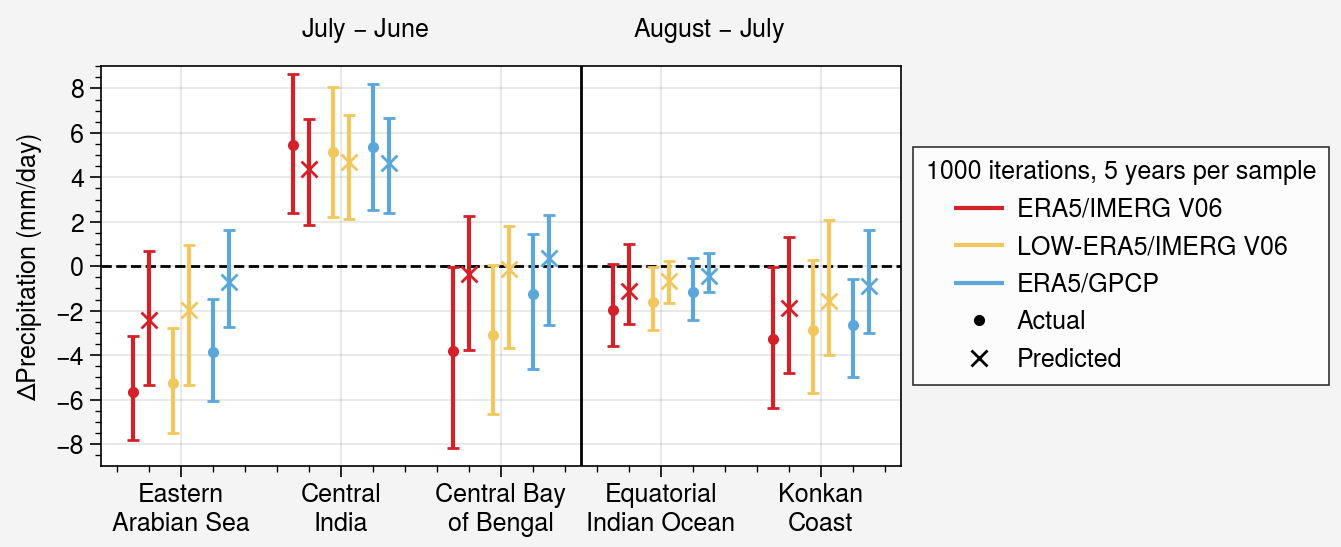

In [7]:
def offset_points(x,offset):
    return [i+offset for i in range(len(x))]

regions  = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
nregions = len(regions)
fig,ax   = pplt.subplots(refheight=2,refwidth=4)
ax.format(ylabel='$\Delta$Precipitation (mm/day)',ylim=(-9,9),yticks=2,xlim=(-0.5,nregions-0.5))
ax.text(x=1.15,y=ax.get_ylim()[1]+1,s='July $-$ June',ha='center',va='bottom')
ax.text(x=3.3,y=ax.get_ylim()[1]+1,s='August $-$ July',ha='center',va='bottom')
ax.axvline(x=2.5,color='k',linewidth=1,zorder=0)
ax.axhline(y=0,linestyle='--',color='k',linewidth=1,zorder=0)

offsets  = [-0.25,0,0.25]
colors   = ['#D42028','#F2C85E','#5BA7DA']
datasets = [
    ('ERA5/IMERG V06',hiimergrealdiff,hiimergrealyerr,hiimergpreddiff,hiimergpredyerr),
    ('LOW-ERA5/IMERG V06',loimergrealdiff,loimergrealyerr,loimergpreddiff,loimergpredyerr),
    ('ERA5/GPCP',logpcprealdiff,logpcprealyerr,logpcppreddiff,logpcppredyerr)]

for (label,realdiff,realyerr,preddiff,predyerr),offset,color in zip(datasets,offsets,colors):
    xreal = offset_points(regions,offset-0.05)
    xpred = offset_points(regions,offset+0.05)
    ax.errorbar(xreal,realdiff,yerr=realyerr,color=color,marker='.',linestyle='',markersize=6,capsize=2,
                label=f'Actual {label}')
    ax.errorbar(xpred,preddiff,yerr=predyerr,color=color,marker='x',linestyle='',markersize=6,capsize=2,
                label=f'Predicted {label}')
handles = [Line2D([0],[0],color=color,label=label) for label,color in zip([ds[0] for ds in datasets],colors)
          ]+[Line2D([0],[0],color='k',marker='.',linestyle='',label='Actual'),
             Line2D([0],[0],color='k',marker='x',linestyle='',label='Predicted')]
ax.legend(handles=handles,loc='r',ncols=1,title=f'{NITERATIONS} iterations, {YEARSINSAMPLE} years per sample')
ax.set_xticks(range(nregions))
ax.set_xticklabels(regions)
pplt.show()

In [9]:
# # Percent error plot
# fig2, ax2 = pplt.subplots(refheight=2, refwidth=4)

# regions = ['Eastern\nArabian Sea', 'Central\nIndia', 'Central Bay\nof Bengal', 'Equatorial\nIndian Ocean', 'Konkan\nCoast']
# nregions = len(regions)

# ax2.format(ylabel='Percent Error (%)', ylim=(0, 100), yticks=20, xlim=(-0.5, nregions-0.5))
# ax2.axvline(x=2.5, color='k', linewidth=1, zorder=0)

# offsets = [-0.25, 0, 0.25]
# colors = ['#D42028', '#F2C85E', '#5BA7DA']
# datasets = [
#     ('ERA5/IMERG V06', hiimergrealdiff, hiimergrealyerr, hiimergpreddiff, hiimergpredyerr),
#     ('LOW-ERA5/IMERG V06', loimergrealdiff, loimergrealyerr, loimergpreddiff, loimergpredyerr),
#     ('ERA5/GPCP', logpcprealdiff, logpcprealyerr, logpcppreddiff, logpcppredyerr)
# ]

# for (label, realdiff, _, preddiff, _), offset, color in zip(datasets, offsets, colors):
#     percent_errors = [calculate_percent_error(real.item(), pred.item()) for real, pred in zip(realdiff, preddiff)]
#     x_positions = offset_points(range(nregions), offset)
#     ax2.bar(x_positions, percent_errors, width=0.2, color=color, alpha=0.7, label=label)

# ax2.legend(loc='r', ncols=1)
# ax2.set_xticks(range(nregions))
# ax2.set_xticklabels(regions)
# ax2.text(x=1.15, y=ax2.get_ylim()[1]+5, s='July $-$ June', ha='center', va='bottom')
# ax2.text(x=3.3, y=ax2.get_ylim()[1]+5, s='August $-$ July', ha='center', va='bottom')

# pplt.show()

## Fig. 2

In [10]:
def calc_actual_bin_mean_pr(data, regions=REGIONS, samplethresh=SAMPLETHRESH):
    regionnames = []
    binmeanprlist = []
    bl_bins = None
    for i, region in enumerate(regions):
        regionnames.append(region)
        monthpair = MONTHPAIRS[0] if i < 3 else MONTHPAIRS[1]
        regiondata = get_month(get_region(data, region), monthpair)
        regionbinmeanpr = []
        for month in monthpair:
            monthdata = get_month(regiondata, month)
            monthstats = calc_binned_stats(monthdata)
            binmeanpr = (monthstats.Q1 / monthstats.Q0).where(monthstats.Q0 >= samplethresh)
            regionbinmeanpr.append(binmeanpr)
            if bl_bins is None:
                bl_bins = monthstats.bl  # Extract bl values from monthstats
        binmeanprlist.append(regionbinmeanpr)
    
    # Create DataArray with correct dimensions
    da = xr.DataArray(binmeanprlist, 
                      dims=['region', 'month', 'bl'],
                      coords={'region': regionnames,
                              'month': ['first', 'second'],
                              'bl': bl_bins})
    
    # Rename 'bl' dimension to 'bl_bin'
    da = da.rename({'bl': 'bl_bin'})
    return da

def calc_bootstrapped_bin_mean_pr(data, niterations=NITERATIONS, yearsinsample=YEARSINSAMPLE, regions=REGIONS, samplethresh=SAMPLETHRESH):
    regionnames = []
    binmeanprensemble = []
    bl_bins = None
    for i, region in enumerate(regions):
        regionnames.append(region)
        monthpair = MONTHPAIRS[0] if i < 3 else MONTHPAIRS[1]
        regiondata = get_month(get_region(data, region), monthpair)
        samples = get_bootstrap_samples(regiondata, niterations, yearsinsample)
        regionbinmeanprsamples = []
        for sample in samples:
            samplebinmeanpr = []
            for month in monthpair:
                monthdata = get_month(sample, month)
                monthstats = calc_binned_stats(monthdata)
                binmeanpr = (monthstats.Q1 / monthstats.Q0).where(monthstats.Q0 >= samplethresh)
                samplebinmeanpr.append(binmeanpr)
                if bl_bins is None:
                    bl_bins = monthstats.bl  # Extract bl values from monthstats
            regionbinmeanprsamples.append(samplebinmeanpr)
        binmeanprensemble.append(regionbinmeanprsamples)
    
    # Create DataArray with correct dimensions
    da = xr.DataArray(binmeanprensemble, 
                      dims=['region', 'iteration', 'month', 'bl'],
                      coords={'region': regionnames,
                              'iteration': range(niterations),
                              'month': ['first', 'second'],
                              'bl': bl_bins})
    
    # Rename 'bl' dimension to 'bl_bin'
    da = da.rename({'bl': 'bl_bin'})
    
    return da

def calc_confidence_intervals(actualvalues,bootstrapensemble,confidence=0.95):
    actualdiff = bootstrapensemble-actualvalues
    lowerpercentile = (1-confidence)/2
    upperpercentile = 1-lowerpercentile
    cilower = actualvalues-actualdiff.quantile(upperpercentile,dim='iteration')
    ciupper = actualvalues-actualdiff.quantile(lowerpercentile,dim='iteration')
    return cilower,ciupper

def calc_bin_mean_pr_with_ci(data, niterations=NITERATIONS, yearsinsample=YEARSINSAMPLE,
                             regions=REGIONS, samplethresh=SAMPLETHRESH):
    actualbinmeanpr = calc_actual_bin_mean_pr(data, regions, samplethresh)
    bootstrappedbinmeanpr = calc_bootstrapped_bin_mean_pr(data, niterations, yearsinsample, regions, samplethresh)
    cilower, ciupper = calc_confidence_intervals(actualbinmeanpr, bootstrappedbinmeanpr)
    
    yerr = xr.concat([actualbinmeanpr - cilower, ciupper - actualbinmeanpr], dim='ci')
    
    return actualbinmeanpr, yerr, bootstrappedbinmeanpr

In [11]:
hiimergactual,hiimergyerr,hiimergbootstrap = calc_bin_mean_pr_with_ci(hiresimergds)
loimergactual,loimergyerr,loimergbootstrap = calc_bin_mean_pr_with_ci(loresimergds)
logpcpactual,logpcpyerr,logpcpbootstrap = calc_bin_mean_pr_with_ci(loresgpcpds)

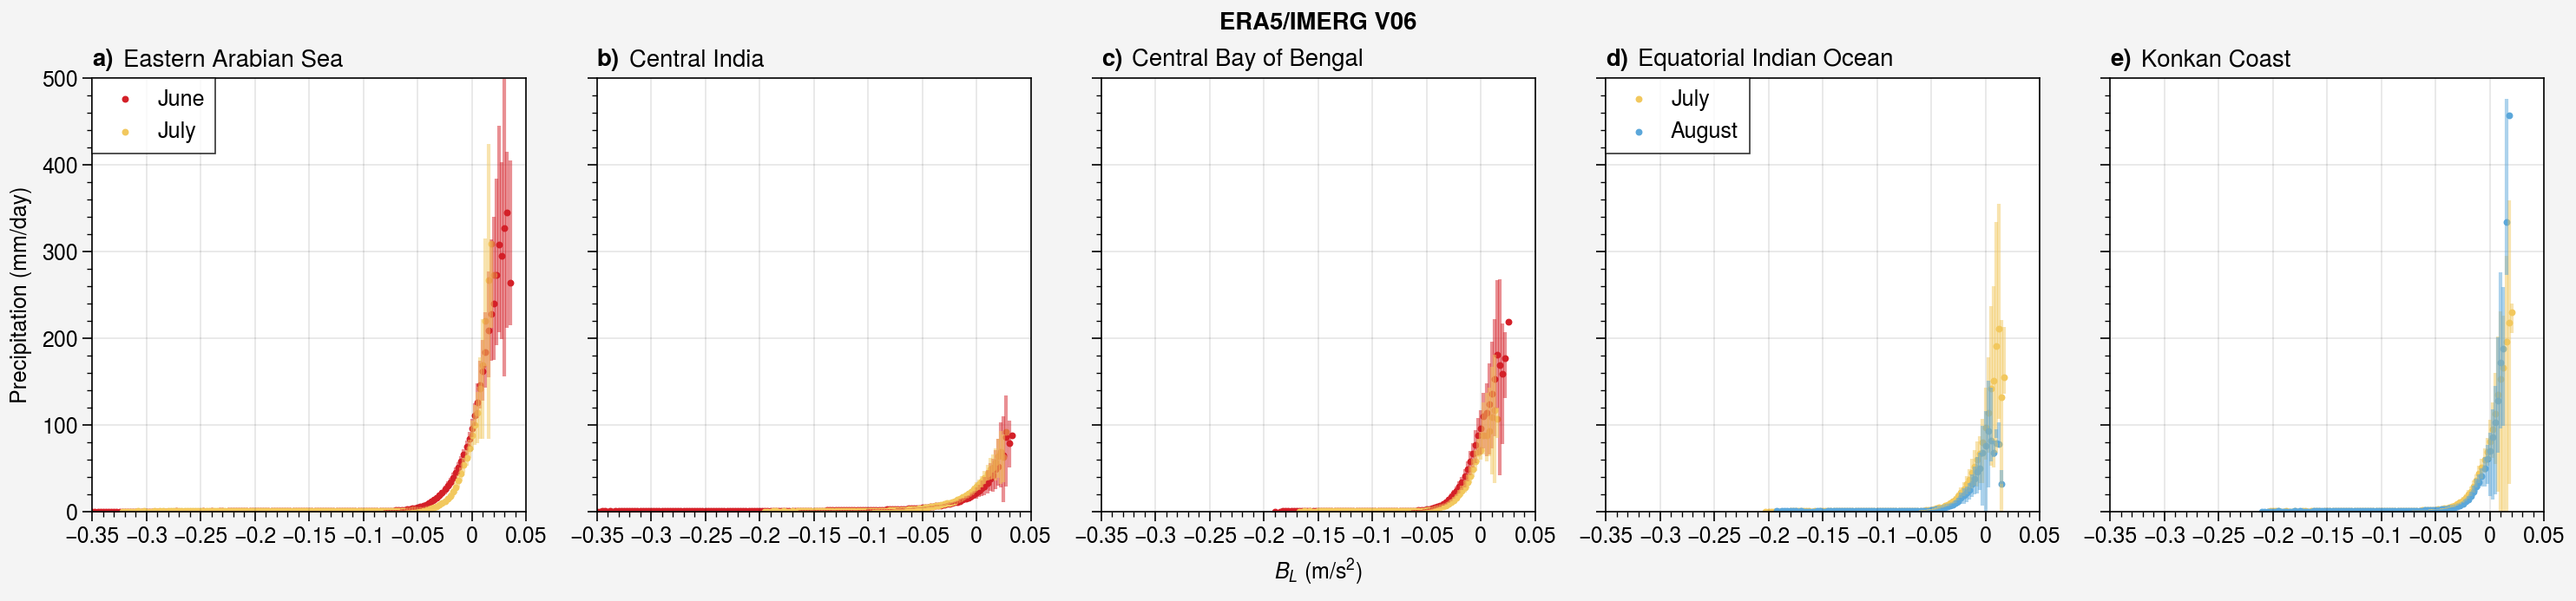

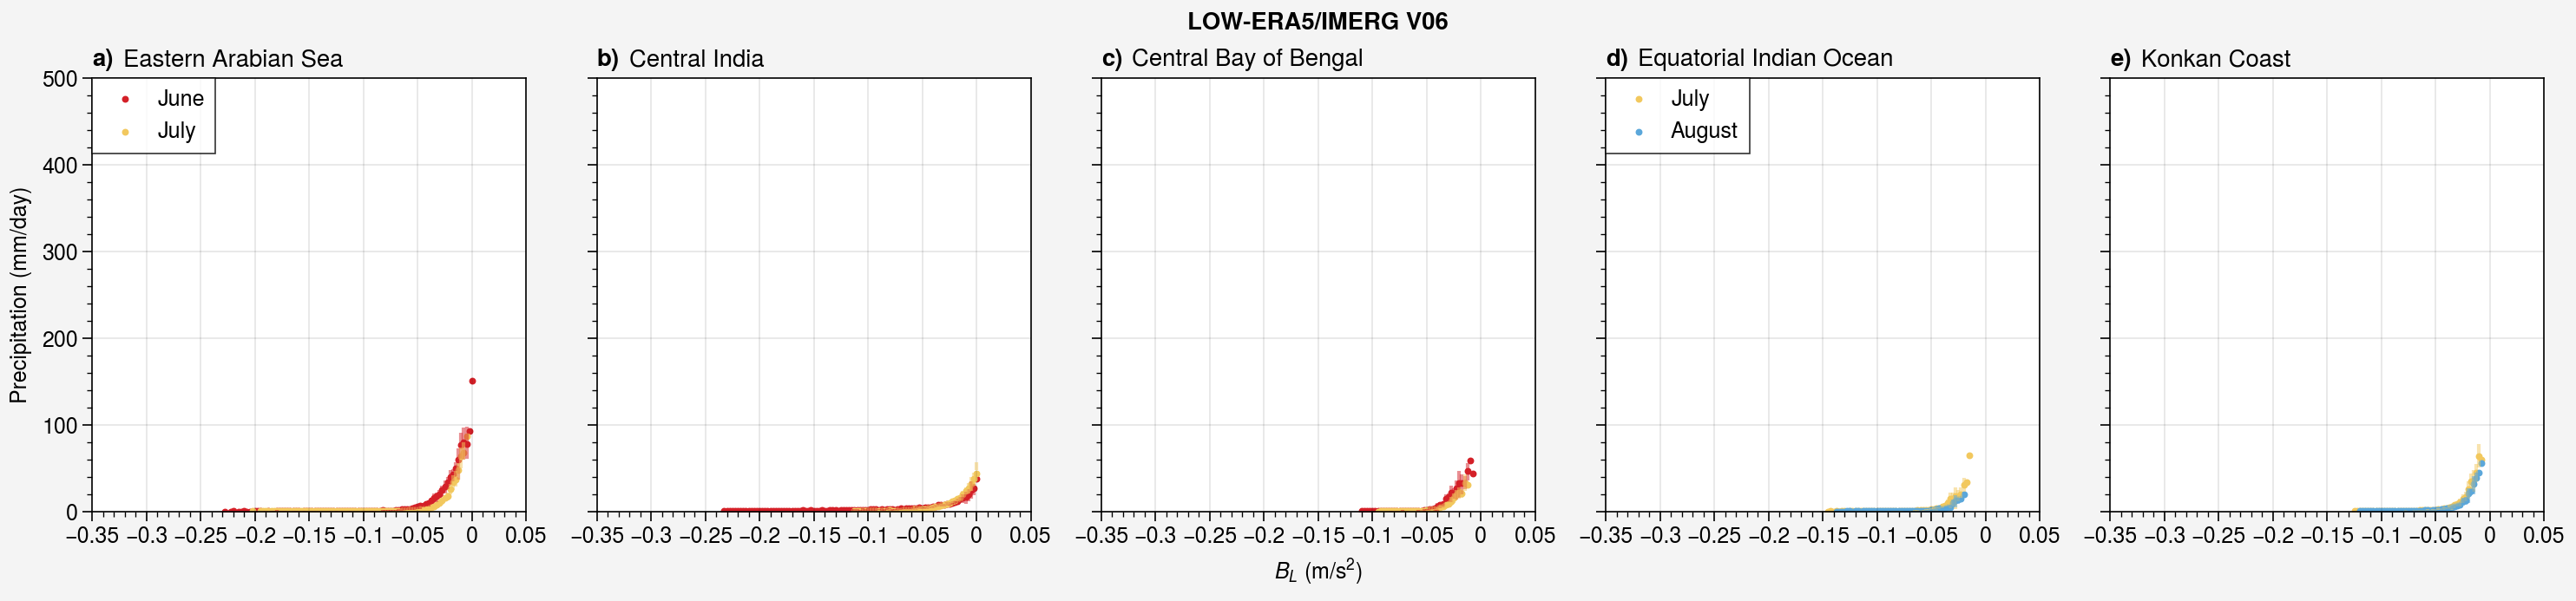

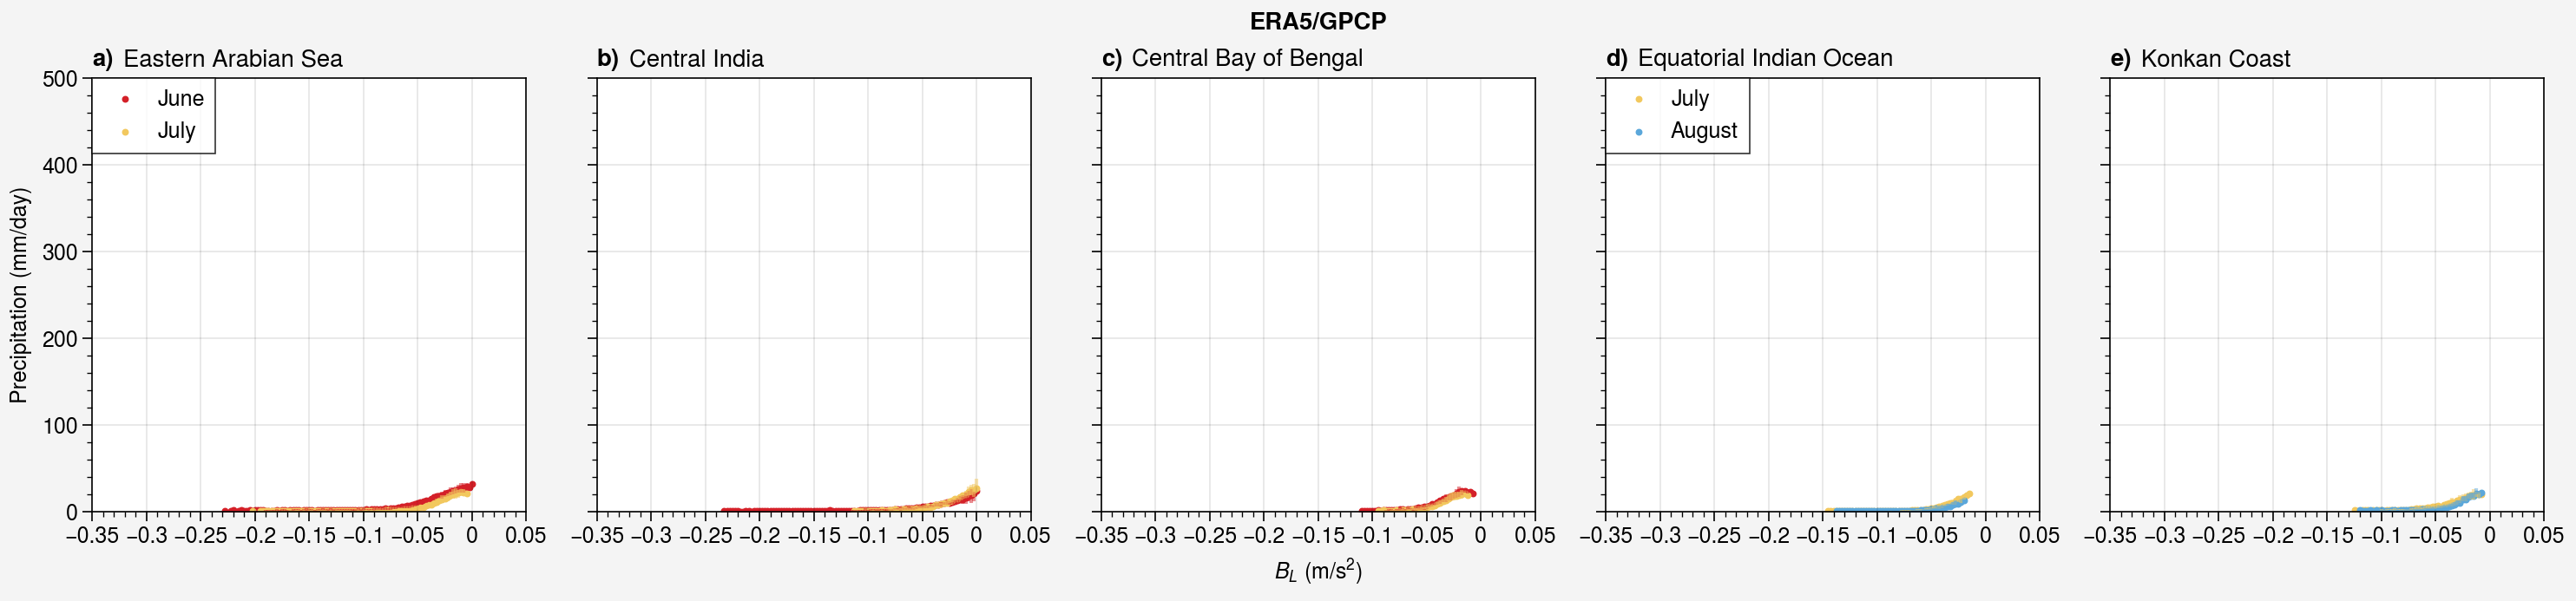

In [17]:
CASES   = {
    'JJ':[(6,'June','#D42028'),(7,'July','#F2C85E')],
    'JA':[(7,'July','#F2C85E'),(8,'August','#5BA7DA')]}


def plot_dataset(data,yerr,datasetname):
    # prkwargs = dict(alpha=0.8,s=50)
    # blkwargs = dict(marker='D',alpha=0.1,s=20)

    # fig = pplt.figure(refaspect=1,refwidth=1.6)
    # axs = fig.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]])
    fig,axs = pplt.subplots(nrows=1,ncols=5,share=True)
    axs.format(suptitle=f'{datasetname}',abcloc='l',abc='a)',xlabel='$\mathit{B_L}$ (m/s$^2$)',
               xticks=0.05,ylabel='Precipitation (mm/day)',yticks=100,
               xlim=(-0.35,0.05),
               ylim=(0,500),
              )

    for i,region in enumerate(data.region.values):
        ax = axs[i]
        ax.format(titleloc='l',title=f'{region}')
        # bx = ax.twinx()
        # bx.format(yscale='log',yformatter='log',ylim=(10e-6, 0.1))
        # if i in [0,1,3]:
        #     bx.format(yticklabels=[])
        casekey = 'JJ' if i<3 else 'JA'
        axnum   = 0 if casekey=='JJ' else 3
        for j,(month,label,color) in enumerate(CASES[casekey]):
            month_label = 'first' if j == 0 else 'second'
            monthdata = data.sel(region=region, month=month_label)
            monthyerr = yerr.sel(region=region, month=month_label)
            
        #     blpdf = get_pdf(monthdata,bintype='1D',precipitating=True)
        #     bx.scatter(blpdf,color=color,**blkwargs)
            
            # Plot bin mean precipitation with error bars
            # ax.errorbar(monthdata.bl_bin,monthdata,yerr=monthyerr,color=color,label=label)

             # Plot scatter points
            ax.scatter(monthdata.bl_bin, monthdata, color=color, label=label,marker='.',s=20)
            
            # Add vertical error bars
            ax.vlines(monthdata.bl_bin, monthdata - monthyerr.sel(ci=0), monthdata + monthyerr.sel(ci=1), 
                      color=color, alpha=0.5)
            
        axs[axnum].legend(loc='ul', ncols=1)
    pplt.show()


datasets = [
    ('ERA5/IMERG V06',hiimergactual,hiimergyerr),
    ('LOW-ERA5/IMERG V06',loimergactual,loimergyerr),
    ('ERA5/GPCP',logpcpactual,logpcpyerr)
]

for datasetname,data,yerr in datasets:
    plot_dataset(data,yerr,datasetname)